<a href="https://colab.research.google.com/github/ndungek/Threads-Reviews-Sentiment-Analysis/blob/main/reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **THREADS REVIEWS SENTIMENT ANALYSIS**


---


*Maureen Kitang'a*

## Abstract
In the bustling world of social media and messaging apps, Threads emerges as a fresh contender, stepping into the limelight in July. As it embarks on its journey in the ever-evolving landscape, we set out to decipher the sentiments of Threads app users through a comprehensive sentiment analysis project.

With a relatively small training dataset consisting of just over 5900 examples, we faced the challenge of skewed data. However, our goal was clear: predict sentiment – be it positive, negative, or neutral – with precision and insight.

This notebook aims to:
* Look for engaging information regarding the reviews.
* Perform data cleaning and preprocessing.
* Build DL models.
* Predict the sentiment of the reviews.

## **IMPORTING LIBRARIES**

In [3]:
#importing libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **LOADING THE DATASET**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os

folder_path = '/content/drive/My Drive/Threads-Reviews-Sentiment-Analysis'
os.chdir(folder_path)

In [6]:
folder_contents = os.listdir()
print(folder_contents)

['threads_reviews.csv', 'README.md', 'LICENSE', '.git', 'reviews.ipynb']


In [7]:
df = pd.read_csv("threads_reviews.csv")

df.head()

,source,review_description,rating,review_date
0,Google Play,Very good app for Android phone and me,5,27-08-2023 10:31
1,Google Play,Sl👍👍👍👍,5,27-08-2023 10:28
2,Google Play,Best app,5,27-08-2023 9:47
3,Google Play,Gatiya app,1,27-08-2023 9:13
4,Google Play,Lit bruv,5,27-08-2023 9:00


In [8]:
def df_shape(df, ds_name):
    print(f"The {ds_name} dataset has {df.shape[0]} rows and {df.shape[1]}")

df_shape(df, "Threads Reviews")

The Threads Reviews dataset has 40435 rows and 4


In [9]:
def df_info(df, ds_name):
    print(f"The {ds_name} dataset info:\n")
    print(df.info())

df_info(df, "Threads Reviews")

The Threads Reviews dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40435 entries, 0 to 40434
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              40435 non-null  object
 1   review_description  40435 non-null  object
 2   rating              40435 non-null  int64 
 3   review_date         40435 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB
None


In [10]:
#Display Unique val in each col
def uni_vals(df, ds_name):
    print(f"The number of unique values in each column in {ds_name} dataset:\n")
    print(df.nunique())

uni_vals(df, "Threads Reviews")

The number of unique values in each column in Threads Reviews dataset:

source                    2
review_description    32894
rating                    5
review_date           16742
dtype: int64


## **DATA CLEANING**

In [11]:
def check_missing(df, ds_name):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_missing(df, "Threads Reviews")

Null Values in each col in the Threads Reviews dataset:

source                0
review_description    0
rating                0
review_date           0
dtype: int64


In [12]:
def check_duplicates(df, ds_name):
    print(f"Duplicate Values in each col in the {ds_name} dataset:\n")
    print(df.duplicated().sum())

check_duplicates(df, "Threads Reviews")

Duplicate Values in each col in the Threads Reviews dataset:

95


In [13]:
# handling the duplicates
def remove_duplicated_rows(data):
    """Simple Function to remove duplicated rows"""
    data.drop_duplicates(subset=None, keep="first", inplace=True)
    return data


df = remove_duplicated_rows(df)

## **EXPLORATORY DATA ANALYSIS**

### **UNIVARIATE ANALYSIS**

#### `Source`

In [14]:
df["source"].value_counts()

Google Play    36628
App Store       3712
Name: source, dtype: int64

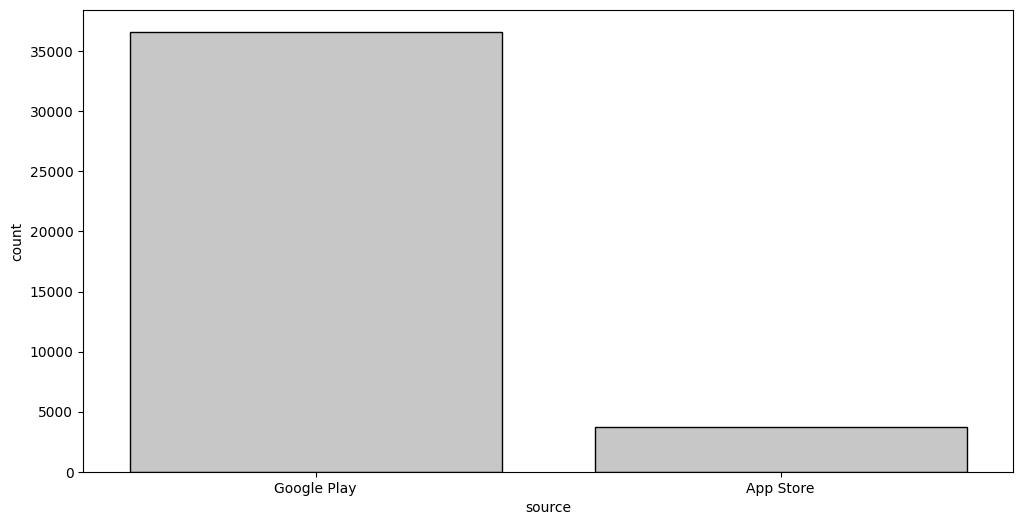

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='source', color = "#C7C7C7", edgecolor='black')
plt.show()

#### `rating`

In [16]:
df['rating'] = df['rating'].astype('int32')

In [17]:
df['rating'].value_counts()

5    18168
1    12914
4     3786
3     3175
2     2297
Name: rating, dtype: int64

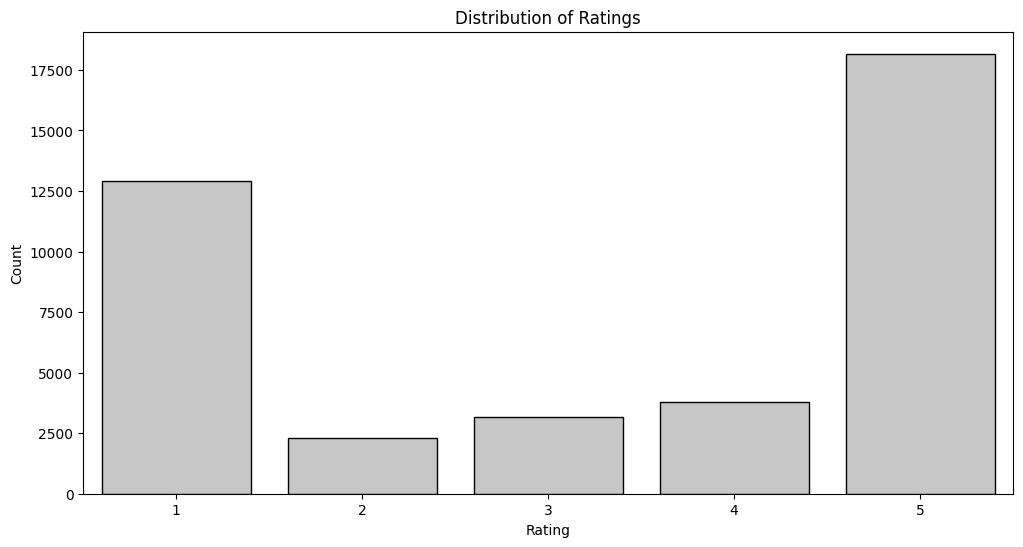

In [18]:
# Create a countplot to visualize the distribution of ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='rating', color='#C7C7C7', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks(rotation=0)
plt.show()

In [19]:
# Replace non-numeric ratings with 'Unknown', and convert others to integers
df['rating'] = df['rating'].replace([1,2], 'bad')
df['rating'] = df['rating'].replace(3, 'neutral')
df['rating'] = df['rating'].replace([4,5], 'good')

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

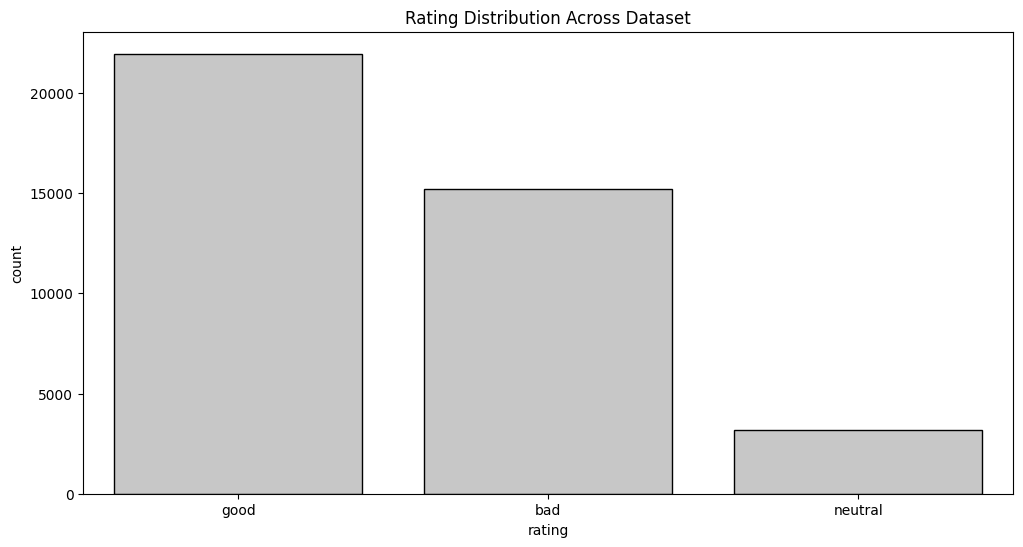

In [20]:
# Create a countplot to visualize the distribution of rating categories
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='rating', color='#C7C7C7', edgecolor='black')
ax.set_title('Rating Distribution Across Dataset')

#### `review_description`

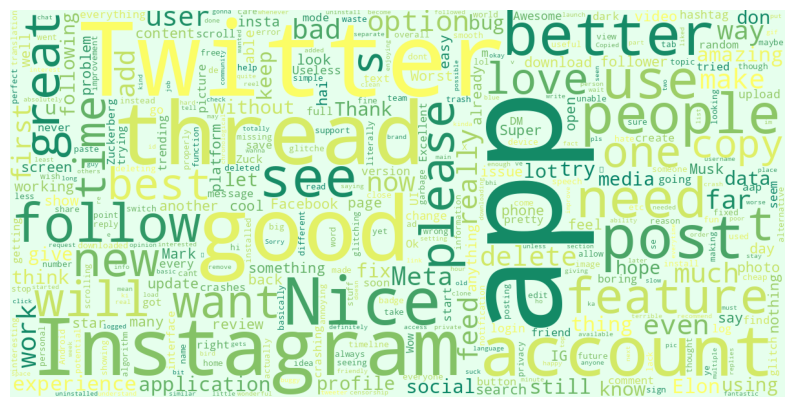

In [21]:
from wordcloud import WordCloud


# Concatenate all reviews into a single string
reviews_text = ' '.join(df['review_description'])

# Create a Word Cloud
plt.figure(figsize=(10, 10))
wc = WordCloud(
    max_words=1000,
    min_font_size=10,
    height=600,
    width=1200,
    collocations=False,
    background_color='#e6ffed',
    colormap='summer'
).generate(reviews_text)

# Display the Word Cloud
plt.axis('off')
plt.imshow(wc)
plt.show()

In [22]:
def top_words(text):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)

    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))
top_words(df['review_description'])

Top 5 words that appear most frequently:

app	--> 11369
Twitter	--> 5485
thread	--> 4396
Instagram	--> 3740
good	--> 3019


#### `review_date`

In [23]:
df['review_date'] = pd.to_datetime(df['review_date'])

df['Date'] = df['review_date'].apply(lambda x: x.date())

reviews_per_day = df.groupby(df['Date']).count()['review_description']
reviews_per_day = reviews_per_day.reset_index()
reviews_per_day['Month'] = reviews_per_day['Date'].apply(lambda x: x.month)

In [24]:
# Group reviews by date and count the number of reviews per day
reviews_per_day = df.groupby('Date').count()['review_description'].reset_index()

# Rename the count column
reviews_per_day.rename(columns={'review_description': 'Total_reviews'}, inplace=True)

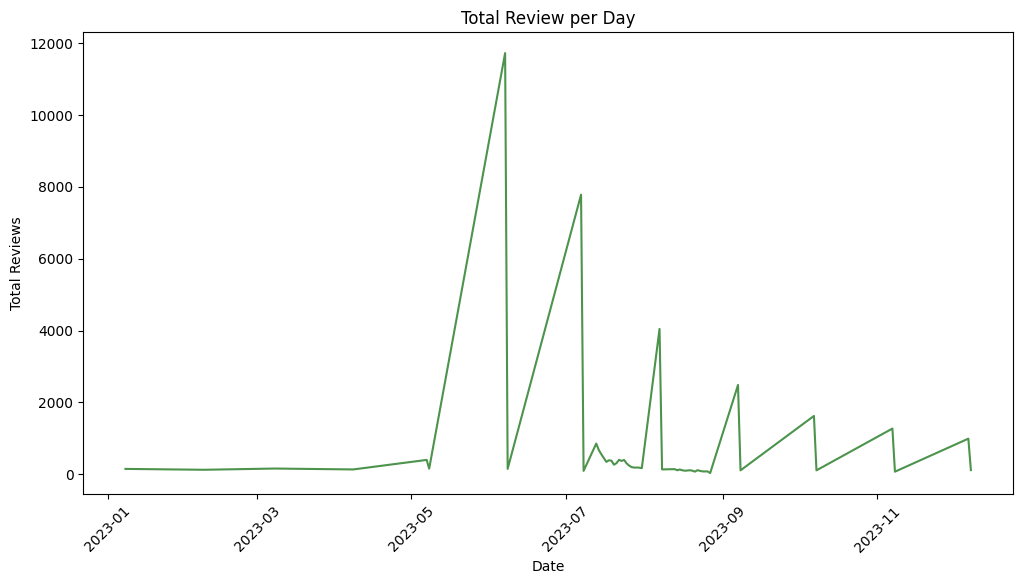

In [25]:
# Create a line plot to visualize the total reviews per day
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=reviews_per_day, x='Date', y='Total_reviews', color='#4c934c')
ax.set_title('Total Review per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Total Reviews')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

### **BIVARIATE ANALYSIS**

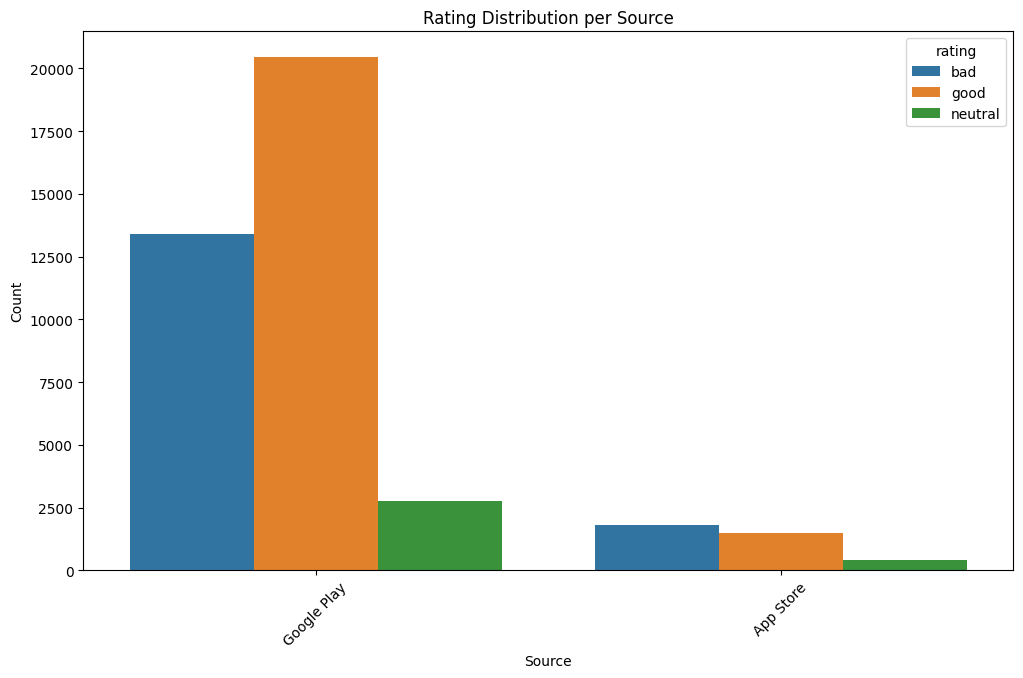

In [26]:
# Group by 'source' and 'emotion' columns to get sentiment counts per source
source_sentiment_group = df.groupby(['source', 'rating'])['rating'].count().reset_index(name='count')

# Calculate the ascending order of sources based on total review count
ascending_order = df['source'].value_counts().index

# Create a bar plot for sentiment distribution per source
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='source', y='count', hue='rating', data=source_sentiment_group, order=ascending_order)
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Rating Distribution per Source')
plt.xticks(rotation=45)
plt.show()


## Data PreProcessing

>> Text data often contains special characters and uppercase letters, which can lead to inconsistencies during analysis. Cleaning the text involves removing special characters and converting text to lowercase for consistency.

In [27]:
# Define a function to clean text by removing special characters and converting to lowercase
def clean_text(text):
    # Remove special characters and numbers, keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

# Apply the clean_text function to the 'review_description' column
df['cleaned_review_description'] = df['review_description'].apply(clean_text)

>> Removing emoticons during data preprocessing is essential for text analysis tasks to reduce noise and ensure consistency in the text data. Emoticons, while expressive, do not carry semantic meaning and can potentially introduce bias or interfere with analysis. By removing them, the focus remains on the meaningful textual content, leading to more accurate and reliable results.

In [28]:
# Define a function to remove emoticons
def remove_emoticons(text):
    # Define a regular expression pattern to match emoticons
    emoticon_pattern = r'(?::|;|=)(?:-)?(?:\)|\(|D|P)'
    # Remove emoticons from the text
    text = re.sub(emoticon_pattern, '', text)
    return text
df['cleaned_review_description'] = df['cleaned_review_description'].apply(remove_emoticons)

>> Tokenization breaks text into individual words or tokens. It's a necessary step for text analysis, as it allows us to work with individual words.

In [29]:
# Define a function for tokenization (splitting text into words)
def tokenize_text(text):
    return word_tokenize(text)

# Apply tokenization to the 'cleaned_review_description' column
df['tokens'] = df['cleaned_review_description'].apply(tokenize_text)


>>  Stopwords are common words (e.g., "the," "and," "is") that don't usually contribute much to the analysis. Removing them reduces noise in the data.

In [30]:
# Get a set of English stopwords
stop_words = set(stopwords.words('english'))

# Define a function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply stopword removal to the 'tokens' column
df['cleaned_tokens'] = df['tokens'].apply(remove_stopwords)

>> Lemmatization reduces words to their base or root form. It ensures that words like "running" and "ran" are treated as the same word ("run"), improving the consistency of the data.

In [31]:
# Initialize a WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function for lemmatization
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to the 'cleaned_tokens' column
df['lemmatized_tokens'] = df['cleaned_tokens'].apply(lemmatize_tokens)

In [32]:
total_words_before_cleaning = df['review_description'].apply(lambda x: len(x.split())).sum()
print('Total words before cleaning: {}'.format(total_words_before_cleaning))


# Calculate and print the total number of words after cleaning
total_words_after_cleaning = df['cleaned_review_description'].apply(lambda x: len(x.split())).sum()
print('Total words after cleaning: {}'.format(total_words_after_cleaning))

Total words before cleaning: 493447
Total words after cleaning: 475334


In [33]:
X_train, X_test, y_train, y_test = train_test_split(df['review_description'], df['rating'], test_size=0.2)

## **MODELING**